In [63]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [64]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4
T_ref = 5
rho = 1.225

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_Temp(df):
    return df / T_ref

@utils.no_kwargs
@utils.dict_apply
def get_Cp(df):
    return df / (0.5 * rho * velTenMeters**2)

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df

In [65]:
run = 46
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [66]:
start = 40000# 30000
stop = -1
by = 1

In [114]:
# probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")


In [115]:
nameKey = read_probes_file_switch(f"{probes_dir}/../locations/nameKey_extraProbe.txt")
nameKey = nameKey.compute()

extraProbe = nameKey.copy()
extraProbe = pd.concat([extraProbe, probes.locations["extraProbe"]], axis = "columns")
df = probes.statistics(
    names = [name for name in  probes.probe_names if "extraProbe" in name], 
    steps = [probes.probe_steps[stop]],
    quants = ["comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"],
    parrallel=False
    )
extraProbe = pd.concat([extraProbe, df], axis = "columns")
extraProbe.set_index(0, inplace=True)
extraProbe = extraProbe.rename(columns=lambda x: f"EP_{x}")
extraProbe = extraProbe.rename(index=lambda x: x.replace("extraProbe_", ''))
display(extraProbe)

# del probes

processing data took 3 seconds


,EP_x,EP_y,EP_z,"EP_comp(u_avg,0)","EP_comp(u_avg,1)","EP_comp(u_avg,2)"
0,,,,,,
roof_sl,44.00,12.0,60.00,0.903852,0.045342,1.077090
xwindow_0-0_sl,36.55,1.5,58.00,0.081421,-0.152485,0.870609
zwindow_0-0_sl,40.00,1.5,54.55,0.623834,-0.048749,0.131952
xwindow_0-1_sl,36.55,1.5,62.00,-0.146850,-0.259822,0.850690
zwindow_0-1_sl,40.00,1.5,65.45,0.327162,-0.273910,0.017727
...,...,...,...,...,...,...
zwindow_0-1_h_0-2_Bxz,-56.00,1.5,-113.45,0.653699,-0.108030,-0.087738
zwindow_1-0_h_0-2_Bxz,-60.00,1.5,-102.55,-0.013746,0.080574,-0.230858
zwindow_1-1_h_0-2_Bxz,-60.00,1.5,-113.45,0.734194,-0.125748,-0.000052


In [69]:
qoisOutputed = [
    "mass_flux",
    "mass_flux(p)",
    "mass_flux(T)",
    "mass_flux(D)",
    "mass_flux(S)",
    "sn_prod(u)",
    "sn_prod(p)",
    "sn_prod(abs(u))",
    "sn_prod(u**2)"
]
qois = qoisOutputed

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type="csv")
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



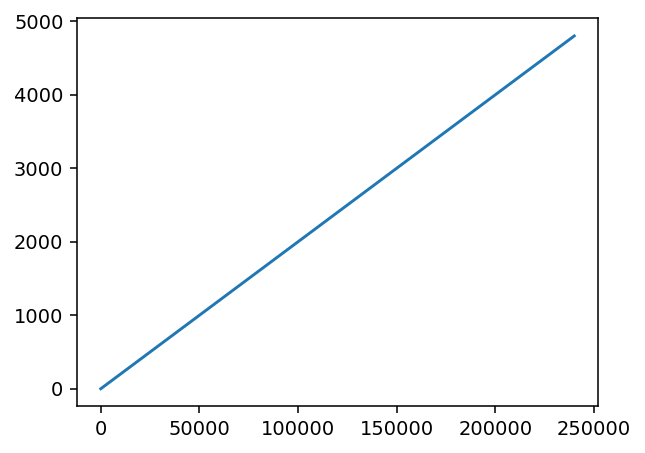

In [70]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [71]:
# plt.figure()
# foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
# foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
# foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
# plt.plot(foo_mass.values/foo_u.values)
# plt.ylim(0,1.225*2)


In [72]:
# plt.figure()
# N = len(foo_mass)
# f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
# plt.loglog(f, E)

## Check Qois


processing data took 1 seconds
processing data took 0 seconds
processing data took 0 seconds


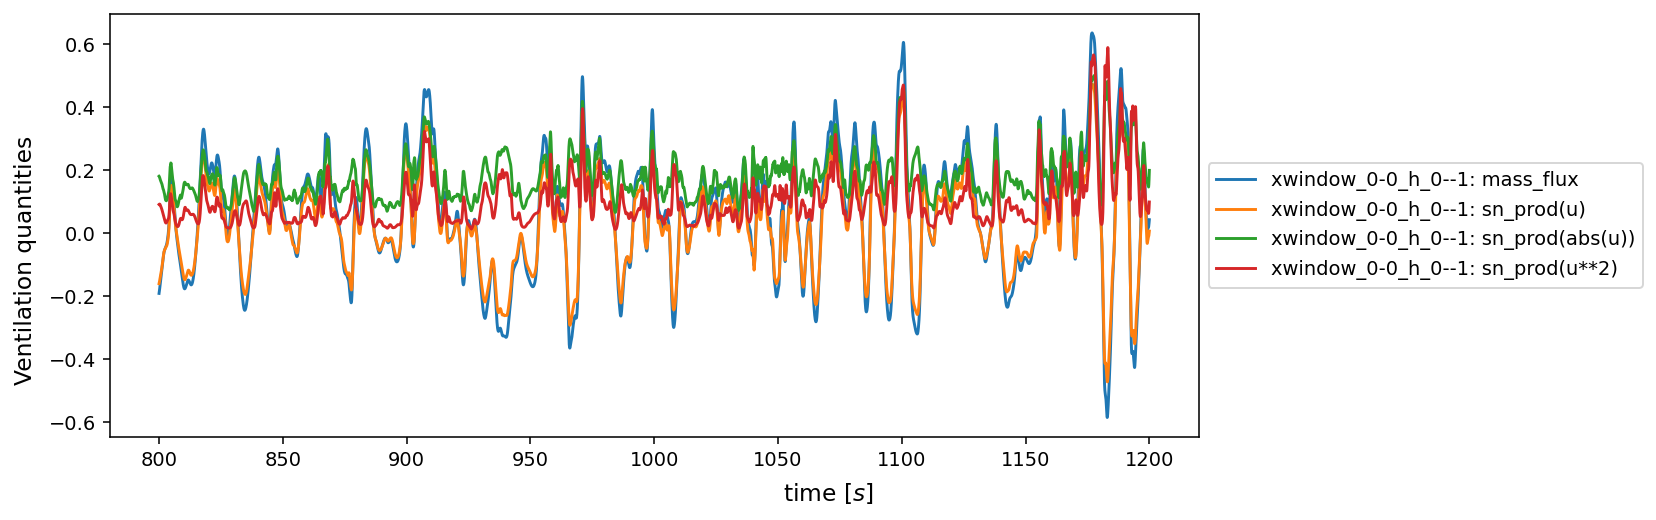

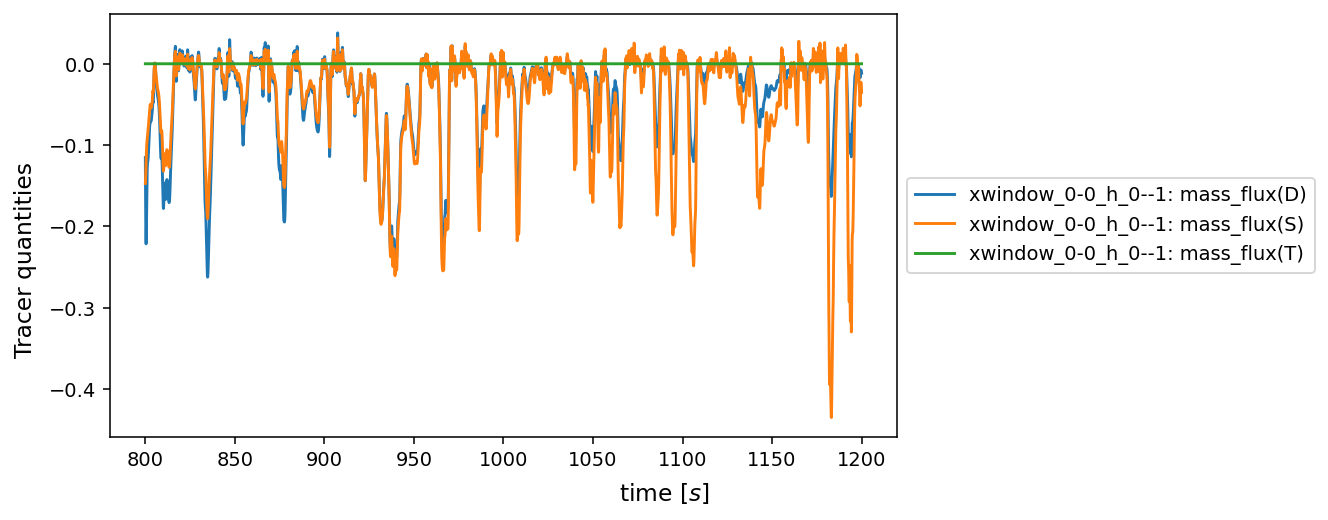

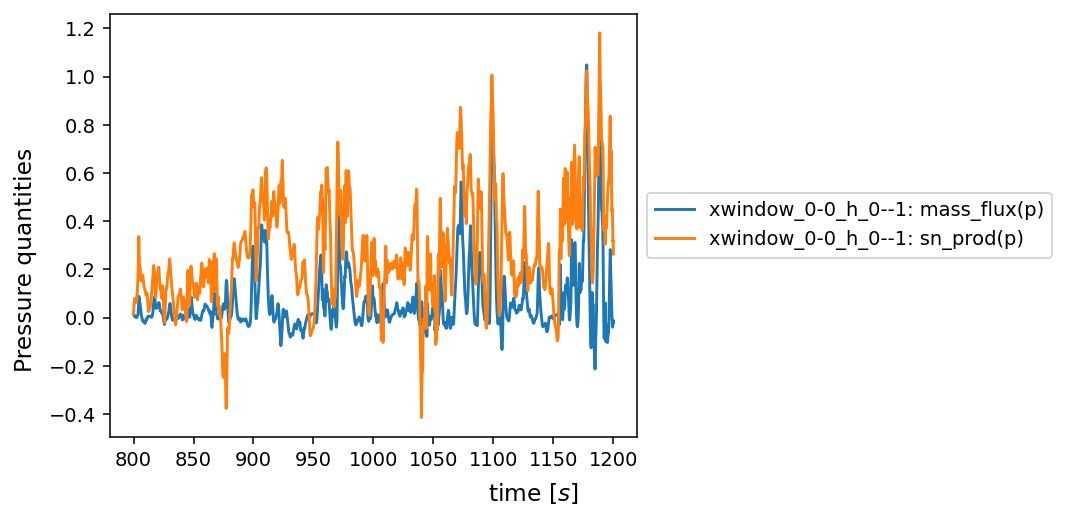

In [73]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow_" in name][0:1], 
    steps = probes.probe_steps[start:60000:by],
    quants = ["mass_flux", "sn_prod(u)", "sn_prod(abs(u))", "sn_prod(u**2)"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Ventilation quantities',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    parrallel=True
    )

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow_" in name][0:1], 
    steps = probes.probe_steps[start:60000:by],
    quants = ["mass_flux(D)", "mass_flux(S)", "mass_flux(T)"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Tracer quantities',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    parrallel=True
    )

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow_" in name][0:1], 
    steps = probes.probe_steps[start:60000:by],
    quants = ["mass_flux(p)", "sn_prod(p)"],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Pressure quantities',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        },
    parrallel=True
    )

In [74]:
qois.remove("mass_flux(p)")
qois

['mass_flux',
 'mass_flux(T)',
 'mass_flux(D)',
 'mass_flux(S)',
 'sn_prod(u)',
 'sn_prod(p)',
 'sn_prod(abs(u))',
 'sn_prod(u**2)']

## X Flow


In [75]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2" and run < 40:
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:60000:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_blocks],
#     parrallel=True
#     )

df = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_norm_blocks],
    parrallel=False
    )

x_mean = df.map(probePost.time_average)
x_rms = df.map(probePost.time_rms)
x_net = df.map(abs)
x_net = x_net.map(probePost.time_average)

dfs_calced = [x_mean, x_rms, x_net]
calcs = ["mean", "rms", "net"]

for i, calc in enumerate(calcs):
    dfs_calced[i].columns = [f"{calc}-{c}" for c in dfs_calced[i].columns]

x_flowStats = pd.concat(dfs_calced, axis = "columns")


processing data took 76 seconds


In [76]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [77]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if fnmatch(name, "*window_?-1*")], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    if category == "config2" and run < 40:
        return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)
    return data_dict

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

df = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

z_mean = df.map(probePost.time_average)
z_rms = df.map(probePost.time_rms)
z_net = df.map(abs)
z_net = z_net.map(probePost.time_average)

dfs_calced = [z_mean, z_rms, z_net]
calcs = ["mean", "rms", "net"]

for i, calc in enumerate(calcs):
    dfs_calced[i].columns = [f"{calc}-{c}" for c in dfs_calced[i].columns]

z_flowStats = pd.concat(dfs_calced, axis = "columns")

processing data took 224 seconds


In [78]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [96]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

df = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [flip_data, norm_norm_blocks],
    parrallel=False
    )

y_mean = df.map(probePost.time_average)
y_rms = df.map(probePost.time_rms)
y_net = df.map(abs)
y_net = y_net.map(probePost.time_average)

dfs_calced = [y_mean, y_rms, y_net]
calcs = ["mean", "rms", "net"]

for i, calc in enumerate(calcs):
    dfs_calced[i].columns = [f"{calc}-{c}" for c in dfs_calced[i].columns]

y_flowStats = pd.concat(dfs_calced, axis = "columns")

processing data took 34 seconds


In [97]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [98]:
def matchNewNamingConvention(input_str):
    # Find the position of the '-' in the string
    split_index = input_str.find('_h_')

    if split_index == -1:
        return input_str #return original if no house number
    
    n1 = int(input_str[split_index+3])
    n2 = int(input_str[split_index+5])
    
    # Modify the numbers
    new_n1 = n1 - 3
    new_n2 = n2 - 2
    
    # Format the output string with the modified numbers
    output_str = f"{new_n1}-{new_n2}"
    
    return f"{input_str[:split_index+3]}{output_str}{input_str[split_index+6:]}"



In [99]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")

locations = probes.get_avg_locations()
locations = locations.loc[flowStats.index.values]
areas = {k: v for k, v in probes.areas.items() if k in flowStats.index}
if category == "config2" and run < 40:
    flowStats = flowStats.rename(index=lambda x: matchNewNamingConvention(x))
    locations = locations.rename(index=lambda x: matchNewNamingConvention(x))
    areas = pd.Series(areas).rename(index=lambda x: matchNewNamingConvention(x))
flowStats = probePost.addWindowDetails(flowStats, locations, areas, extraProbe)


# apply proper post processing to qois
for qoi in x_flowStats.columns.values:
    if fnmatch(qoi, '*mass_flux*') or fnmatch(qoi, '*sn_prod(*u*)'):
        flowStats[qoi] = flowStats[qoi].apply(norm_vent)
    if fnmatch(qoi, '*sn_prod(u**2)"'):
        flowStats[qoi] = flowStats[qoi].apply(norm_vel) # normalize again because velocity squared
    if fnmatch(qoi, '*mass_flux(T)'):
        flowStats[qoi] = flowStats[qoi].apply(norm_Temp)
    if fnmatch(qoi, '*sn_prod(p)'):
        flowStats[qoi] = flowStats[qoi].apply(get_Cp)

In [100]:
roomQois = ["EP_normal", "EP_shear", "EPR_mag"]
roomQois += [q for q in x_flowStats.columns.values if 'rms-' not in q]
roomQois.append("rms-sn_prod(p)")
roomQois += ['x', 'y', 'z', 'openingType', 'windowNumber']

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}
sort_order = ["blockType", "houseType", "roomType"]
roomVentilation = probePost.roomStatistics(flowStats, connectedWindows, roomQois)

roomVentilation = roomVentilation.sort_values(by = sort_order)
sort_order.append("windowType")
flowStats = flowStats.sort_values(by = sort_order)

roomVentilation["nWindows"] = roomVentilation[roomQois[0]].apply(lambda l: len(l))
roomVentilation["contResid"] = roomVentilation['mean-mass_flux'].apply(lambda l: np.mean(l))

roomVentilation

,EP_normal,EP_shear,EPR_mag,mean-mass_flux,mean-mass_flux(D),mean-mass_flux(S),mean-mass_flux(T),mean-sn_prod(abs(u)),mean-sn_prod(p),mean-sn_prod(u),...,x,y,z,openingType,windowNumber,houseType,blockType,roomType,nWindows,contResid
corner_h_0--1_B,"[0.091733571, 0.10439499789021357]","[0.6840506551765898, 0.5294502772556557]","[1.2724986824449656, 1.2724986824449656]","[0.009544392523955886, -0.009281218090052222]","[-0.007532559111490147, -0.007968652289762632]","[-0.023694349286537113, -0.02838520021972983]","[-0.016077671421522683, -0.013109866724263008]","[0.07000574600095111, 0.06312865168676221]","[0.01841507582823618, 0.018367262653823664]","[0.0037943566022953664, -0.006338961672145175]",...,"[46.032316, 47.998871]","[1.5, 1.4952304]","[34.0, 32.1111]","[xwindow, zwindow]","[0-0, 0-0]",0--1,B,corner,2,0.000132
cross_h_0--1_B,"[0.1438817816013153, 0.14792939]","[0.6362816264210011, 0.24961239378324648]","[1.2724986824449656, 1.2724986824449656]","[0.018715729846418883, -0.01893037024797918]","[-0.009212478398497238, -0.017199945627602135]","[-0.013941963275907646, -0.030890907209347604]","[-0.006567513970574651, -0.024694143229946133]","[0.05682252149941998, -0.05339755382353778]","[0.007572416052166682, -0.004840054903933328]","[0.013735237709092254, -0.015143043184667372]",...,"[55.999546, 56.0]","[1.4951899, 1.5]","[32.111137, 39.95937]","[zwindow, zwindow]","[2-0, 2-1]",0--1,B,cross,2,-0.000107
dual_h_0--1_B,"[-0.13283556235256383, -0.055619998, 0.15964494]","[0.6873394956339345, 0.08419155919489375, 0.21...","[1.2724986824449656, 1.2724986824449656, 1.272...","[0.03874306292778891, -0.0799232063517338, 0.0...","[-0.002830501922914527, -0.024722423364287767,...","[-0.007257599666157655, -0.06097383891246587, ...","[-0.004306888160317802, -0.03775473637055689, ...","[0.056775215131053346, -0.07188741131986222, -...","[-0.0025577962491041234, 0.012063759989360377,...","[0.021544518625921164, -0.06361795336752701, 0...",...,"[46.027321, 48.0, 52.0]","[1.5000661, 1.5, 1.5]","[37.999542, 39.959249, 39.959666]","[xwindow, zwindow, zwindow]","[0-1, 0-1, 1-1]",0--1,B,dual,3,0.000397
single_h_0--1_B,[0.09026790139433348],[0.5810726163258212],[1.2724986824449656],[-0.0003703808029007942],[-0.009127239848766643],[-0.01227702745604489],[-0.00928773957590569],[0.03470502355934667],[0.014226611919670524],[-0.001983810924079599],...,[51.998942],[1.4951536],[32.111106],[zwindow],[1-0],0--1,B,single,1,-0.000370
corner_h_0--2_B,"[-0.011279368, 0.44324452]","[1.020500847259345, 0.22771125570976694]","[1.5953091784787745, 1.5953091784787745]","[-0.14038709525861176, 0.13855185397210082]","[-0.016174370461158376, -0.00010167103889413903]","[-0.08079927709507752, -0.0009683363340262353]","[-0.0516167719722679, -0.0006819734900424539]","[0.12362579085517329, 0.11752796759518443]","[0.005038983148308384, 0.030128361623367888]","[-0.11259678220599212, 0.10864379963145887]",...,"[54.032272, 56.0]","[1.5, 1.5]","[10.0, 8.044901]","[xwindow, zwindow]","[0-0, 0-0]",0--2,B,corner,2,-0.000918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
single_h_0-2_Bz,[0.13779893356005507],[0.7700678208112149],[1.8132294806158709],[0.0004428380085603746],[-0.010449487605114268],[-0.01619833922602022],[-0.009968648818291554],[0.042501828244417776],[0.03121746408949734],[-0.004858189955571351],...,[104.02334],[1.4994204],[-59.997758],[zwindow],[1-0],0-2,Bz,single,1,0.000443
corner_sl_Bz,"[-0.10297943792545389, -0.0020239277520736317,...","[1.5545883177766626, 0.21411973885516467, 1.09...","[1.9651079389312383, 1.9651079389312383, 1.965...","[0.03202486975819667, -0.1548510633283611, 0.1...","[-0.0017050812632235133, -0.015096201153524174...","[-0.01128348696396577, -0.08044574723377944, 0...","[-0.011384672089557357, -0.04192152130516641, ...","[-0.07824126833563555, 0.1364174735684444, 0.1...","[0.008596690601804662, -0.031123892011320247, ...","[0.027775586126576074, -0.12815817550312555, 0...",...,"[58.00309, 58.00240

In [101]:

for qoi in roomQois:
    if fnmatch(qoi, '*mass_flux') or fnmatch(qoi, '*sn_prod(u)') or fnmatch(qoi, '*sn_prod(abs(u))'):  # flow quantities
        roomVentilation[qoi] = roomVentilation[qoi].apply(lambda l : sum(np.abs(l))/2)
    if fnmatch(qoi, '*mass_flux(?)') or fnmatch(qoi, '*sn_prod(u**2)') or fnmatch(qoi, 'rms-sn_prod(p)'): # net quantities
        roomVentilation[qoi] = roomVentilation[qoi].apply(lambda l : sum(l))
    elif fnmatch(qoi, '*sn_prod(p)'):
        roomVentilation[qoi] = roomVentilation[qoi].apply(lambda l : sum(l))
    elif qoi in ['x', 'y', 'z']:
        roomVentilation[qoi] = roomVentilation[qoi].apply(lambda l : np.mean(l))
roomVentilation["EPR_mag"] = roomVentilation["EPR_mag"].apply(lambda l: np.mean(l))
roomVentilation["EP_shear"] = roomVentilation["EP_shear"].apply(lambda l: sum(l))
roomVentilation["EP_normal_mag"] = roomVentilation["EP_normal"].apply(lambda l: sum(np.abs(l)))
roomVentilation["EP_normal_sum"] = roomVentilation["EP_normal"].apply(lambda l: abs(sum(l)))
roomVentilation["EP_normal_ratio"] = roomVentilation["EP_normal_mag"] / (roomVentilation["EP_normal_mag"] + roomVentilation["EP_normal_sum"])
display(roomVentilation)
display(flowStats)

,EP_normal,EP_shear,EPR_mag,mean-mass_flux,mean-mass_flux(D),mean-mass_flux(S),mean-mass_flux(T),mean-sn_prod(abs(u)),mean-sn_prod(p),mean-sn_prod(u),...,openingType,windowNumber,houseType,blockType,roomType,nWindows,contResid,EP_normal_mag,EP_normal_sum,EP_normal_ratio
corner_h_0--1_B,"[0.091733571, 0.10439499789021357]",1.213501,1.272499,0.009413,-0.015501,-0.052080,-0.029188,0.066567,0.036782,0.005067,...,"[xwindow, zwindow]","[0-0, 0-0]",0--1,B,corner,2,0.000132,0.196129,0.196129,0.500000
cross_h_0--1_B,"[0.1438817816013153, 0.14792939]",0.885894,1.272499,0.018823,-0.026412,-0.044833,-0.031262,0.055110,0.002732,0.014439,...,"[zwindow, zwindow]","[2-0, 2-1]",0--1,B,cross,2,-0.000107,0.291811,0.291811,0.500000
dual_h_0--1_B,"[-0.13283556235256383, -0.055619998, 0.15964494]",0.981611,1.272499,0.080519,-0.029787,-0.073615,-0.045456,0.090451,0.014598,0.059201,...,"[xwindow, zwindow, zwindow]","[0-1, 0-1, 1-1]",0--1,B,dual,3,0.000397,0.348101,0.028811,0.923561
single_h_0--1_B,[0.09026790139433348],0.581073,1.272499,0.000185,-0.009127,-0.012277,-0.009288,0.017353,0.014227,0.000992,...,[zwindow],[1-0],0--1,B,single,1,-0.000370,0.090268,0.090268,0.500000
corner_h_0--2_B,"[-0.011279368, 0.44324452]",1.248212,1.595309,0.139469,-0.016276,-0.081768,-0.052299,0.120577,0.035167,0.110620,...,"[xwindow, zwindow]","[0-0, 0-0]",0--2,B,corner,2,-0.000918,0.454524,0.431965,0.512724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
single_h_0-2_Bz,[0.13779893356005507],0.770068,1.813229,0.000221,-0.010449,-0.016198,-0.009969,0.021251,0.031217,0.002429,...,[zwindow],[1-0],0-2,Bz,single,1,0.000443,0.137799,0.137799,0.500000
corner_sl_Bz,"[-0.10297943792545389, -0.0020239277520736317,...",2.866465,1.965108,0.153351,-0.016286,-0.089404,-0.052043,0.160620,-0.027397,0.120491,...,"[skylight, xwindow, zwindow]","[0-0, 0-0, 0-0]",sl,Bz,corner,3,-0.001000,0.262295,0.052288,0.833786
cross_sl_Bz,"[-0.11464832465428329, -0.015275104, 0.1572311...",4.410972,1.965108,0.345970,-0.032554,-0.207332,-0.120341,0.295144,0.085871,0.265355,...,"[skylight, skylight, zwindow, zwindow]","[2-0, 2-1, 2-0, 2-1]",sl,Bz,cross,4,0.001799,0.322610,0.008148,0.975365
dual_sl_Bz,"[-0.122273891942937, -0.004475980844965506, 0....",4.477344,1.965108,0.314895,-0.032069,-0.162902,-0.111029,0.261051,0.058754,0.239550,...,"[skylight, skylight, xwindow, zwindow, zwindow]","[0-1, 1-1, 0-1, 0-1, 1-1]",sl,Bz,dual,5,0.001771,0.901588,0.648088,0.581791


,mean-mass_flux,mean-mass_flux(D),mean-mass_flux(S),mean-mass_flux(T),mean-sn_prod(abs(u)),mean-sn_prod(p),mean-sn_prod(u),mean-sn_prod(u**2),rms-mass_flux,rms-mass_flux(D),...,"EP_comp(u_avg,0)","EP_comp(u_avg,1)","EP_comp(u_avg,2)",EP_mag,EP_vel_orientation,EP_normal,EP_shear,EPR_mag,EPR_vel_orientation,roomType
xwindow_0-0_h_0--1,0.009544,-0.007533,-0.023694,-0.016078,0.070006,0.018415,0.003794,0.034993,0.078010,0.016052,...,0.091734,-0.131531,0.671286,0.690174,97.637994,0.091734,0.684051,1.272499,54.862338,corner
zwindow_0-0_h_0--1,-0.009281,-0.007969,-0.028385,-0.013110,0.063129,0.018367,-0.006339,0.028714,0.077556,0.017191,...,0.529348,-0.005633,0.104761,0.539644,101.154280,0.104395,0.529450,1.272499,54.862338,corner
zwindow_2-0_h_0--1,0.018716,-0.009212,-0.013942,-0.006568,0.056823,0.007572,0.013735,0.024064,0.060750,0.017150,...,0.636233,-0.003374,0.144057,0.652347,102.741943,0.143882,0.636282,1.272499,54.862338,cross
zwindow_2-1_h_0--1,-0.018930,-0.017200,-0.030891,-0.024694,-0.053398,-0.004840,-0.015143,-0.019388,0.060379,0.024766,...,0.202959,0.145307,-0.147929,0.290154,120.652525,0.147929,0.249612,1.272499,54.862338,cross
xwindow_0-1_h_0--1,0.038743,-0.002831,-0.007258,-0.004307,0.056775,-0.002558,0.021545,0.022435,0.044458,0.006988,...,-0.132622,-0.178225,0.663874,0.700058,79.061838,-0.132836,0.687339,1.272499,54.862338,dual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xwindow_0-1_sl_Bz,0.084769,0.000117,-0.001084,0.000355,0.082228,-0.008404,0.064761,0.040482,0.064500,0.002566,...,0.674320,0.024947,-0.387361,0.778061,119.855409,0.387329,0.674800,1.965108,49.430578,dual
zwindow_0-1_sl_Bz,0.152826,0.000543,0.002841,0.001574,-0.124091,0.008084,0.118884,-0.078051,0.050929,0.002318,...,-0.219171,0.107950,0.294765,0.382852,124.932306,0.219224,0.313873,1.965108,49.430578,dual
zwindow_1-1_sl_Bz,0.081728,-0.000553,-0.001548,0.000603,-0.080125,0.013205,0.062638,-0.037478,0.059913,0.005968,...,-0.168558,-0.010203,0.240513,0.293875,124.934614,0.168285,0.240921,1.965108,49.430578,dual
skylight_1-0_sl_Bz,-0.050197,-0.012253,-0.043962,-0.036590,-0.060630,-0.015646,-0.037725,-0.023793,0.059016,0.022791,...,0.823604,0.157362,1.280321,1.530460,84.140634,-0.156240,1.522465,1.965108,49.430578,single


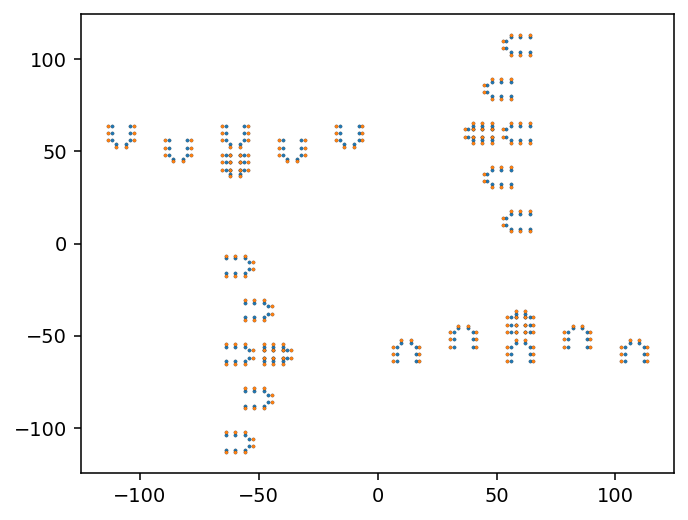

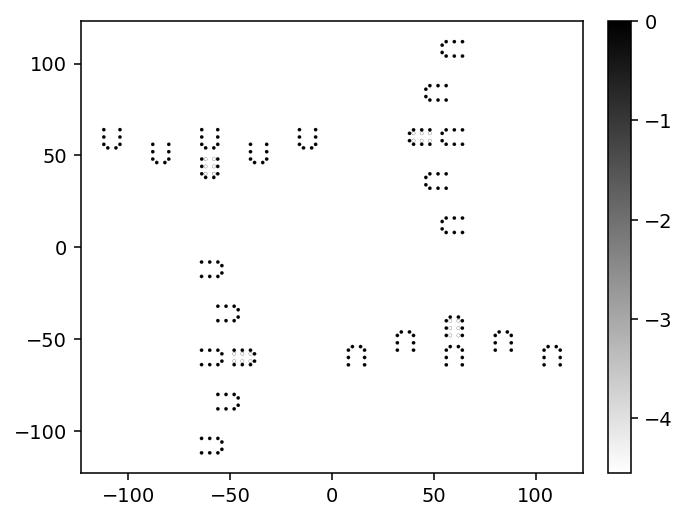

In [102]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, edgecolors="black", linewidths=.1)
im=ax.scatter(flowStats['EP_x'], flowStats['EP_z'], s=4*im_scaling, edgecolors="black", linewidths=.1)


fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["y"] - flowStats["EP_y"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)


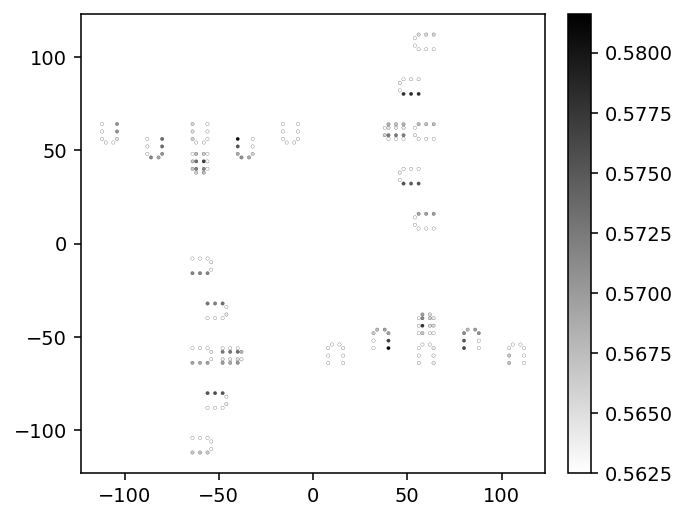

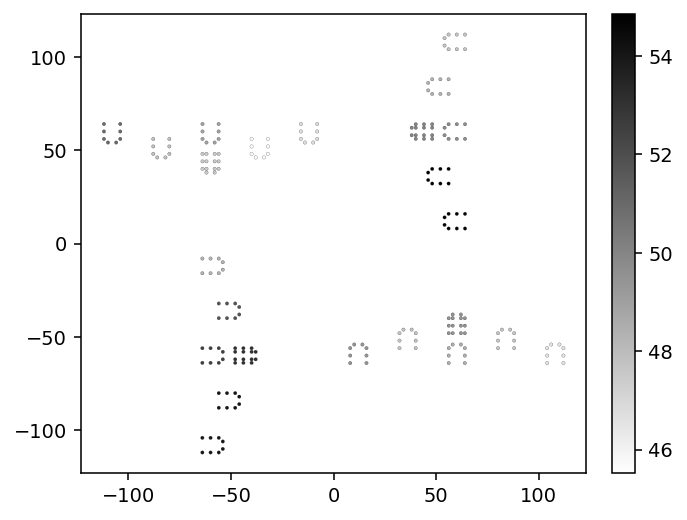

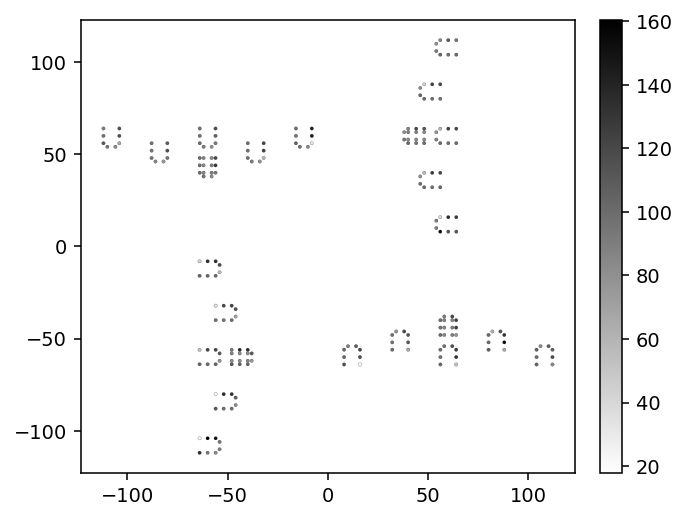

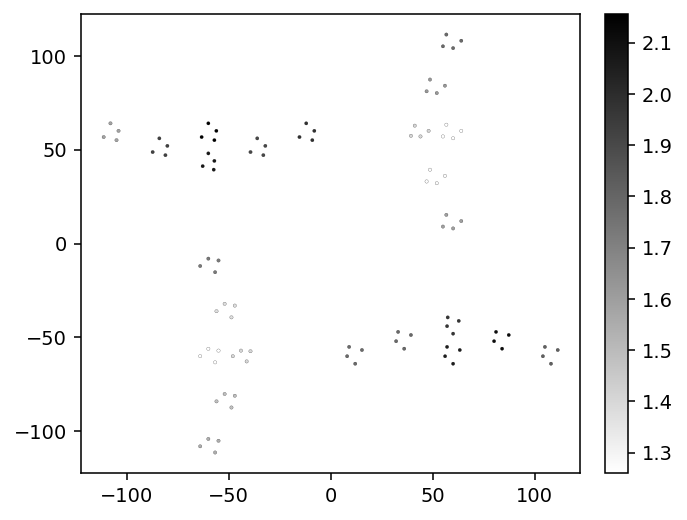

In [103]:

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["area"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["EPR_vel_orientation"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["EP_vel_orientation"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["EPR_mag"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

In [104]:
fig = px.scatter(data_frame = flowStats, x = "EPR_mag", y = "mean-mass_flux", color = "roomType", symbol="roomType")
fig.update_xaxes(title_text='2H Wind Speed')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()
 
fig = px.scatter(data_frame = flowStats, x = "EP_normal", y = "mean-mass_flux", color = "EP_shear", symbol = "roomType")
fig.update_xaxes(title_text='Component of Wind Normal to Window')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()

In [105]:
fig = px.scatter(data_frame = roomVentilation, x = "EPR_mag", y = "mean-mass_flux", color = "roomType", symbol="roomType")
fig.update_xaxes(title_text='2H Wind Speed')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()
 
fig = px.scatter_3d(data_frame = roomVentilation, x = "EP_normal_mag", y = "EP_normal_sum",  z = "mean-mass_flux", color = "roomType", symbol = "roomType")
fig.update_xaxes(title_text='Magnitude/Sum of Window Normal Velocities')
fig.update_yaxes(title_text='Normalized Ventilation Rate')
# fig.update_coloraxes(title_text='Local Wind Magnitude')
fig.show()

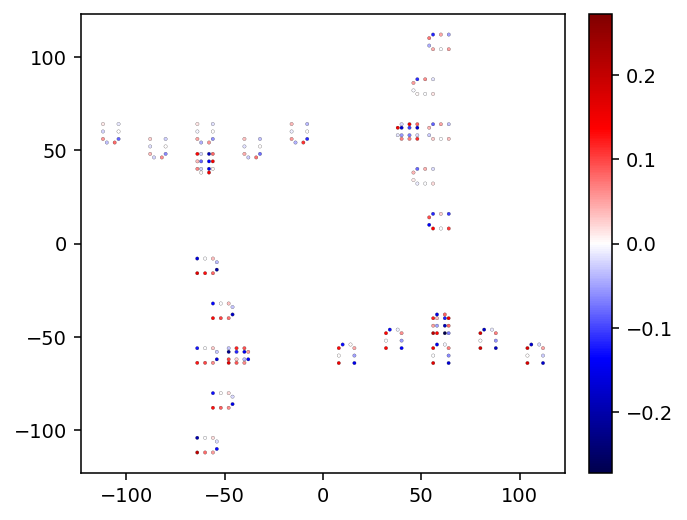

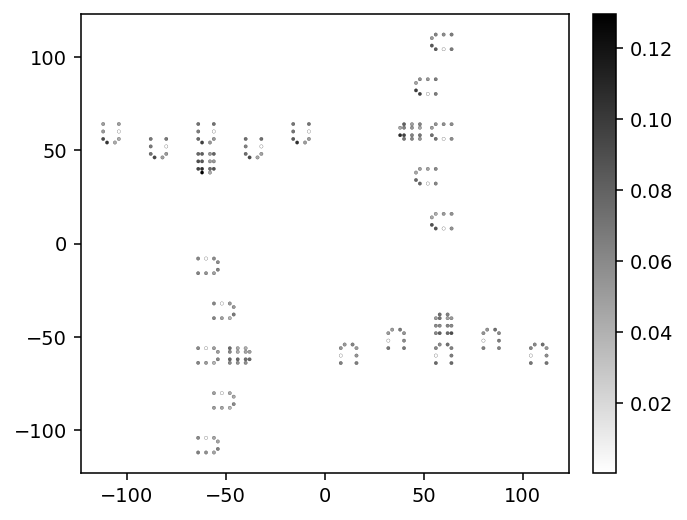

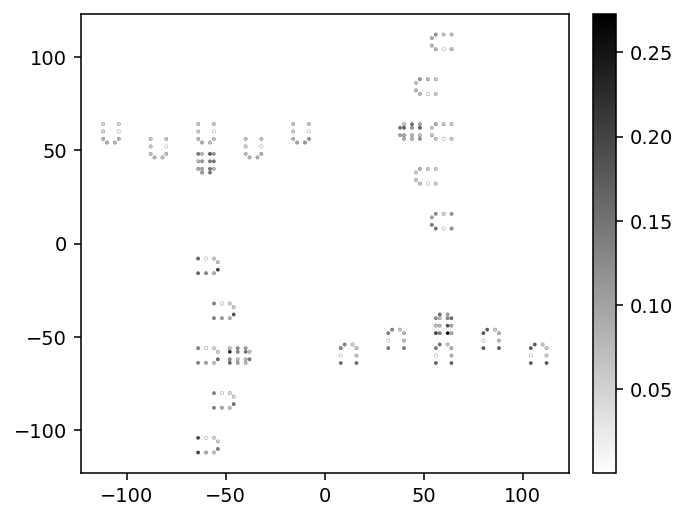

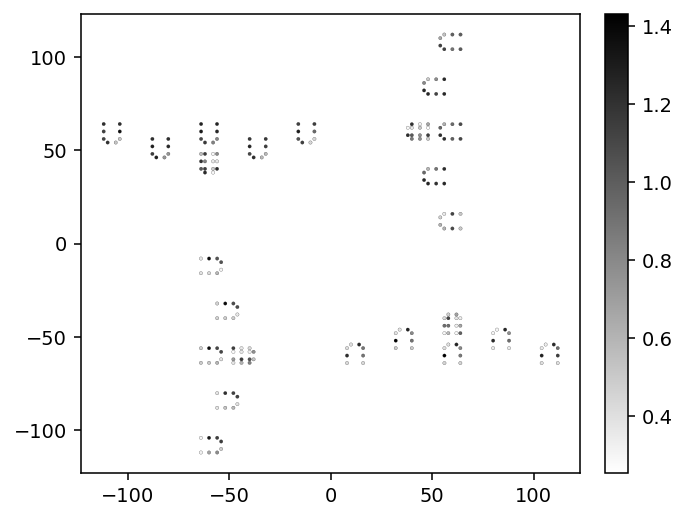

In [106]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-mass_flux"], cmap='seismic', edgecolors="black", linewidths=.1, norm=colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/mean-mass_fluxInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rms-mass_fluxInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/net-mass_fluxInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["rms-mass_flux"]/flowStats["net-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rms-mass_fluxOnet-mass_fluxInterior', bbox_inches="tight")

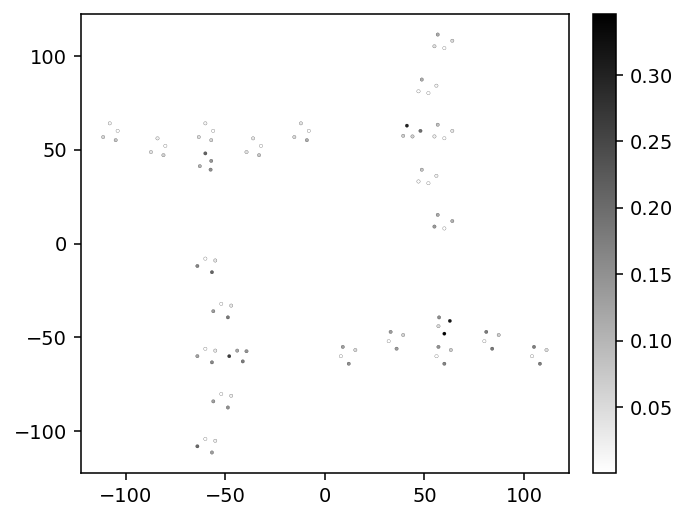

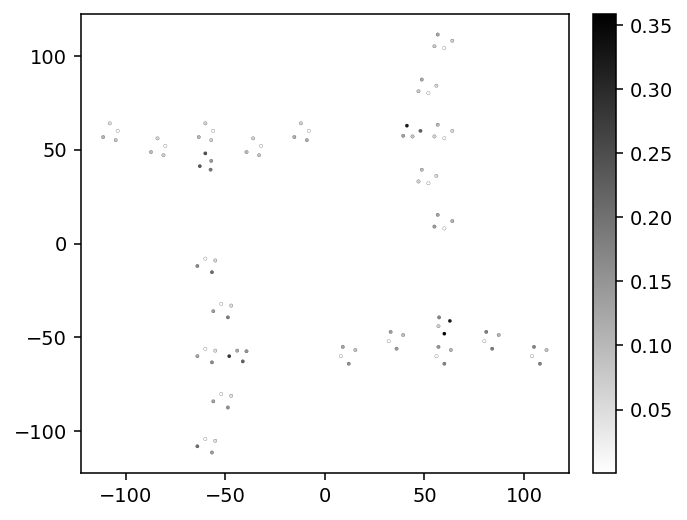

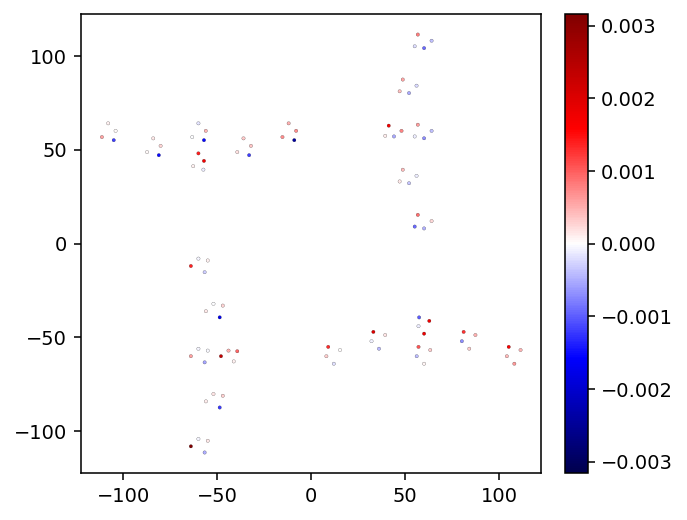

In [107]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

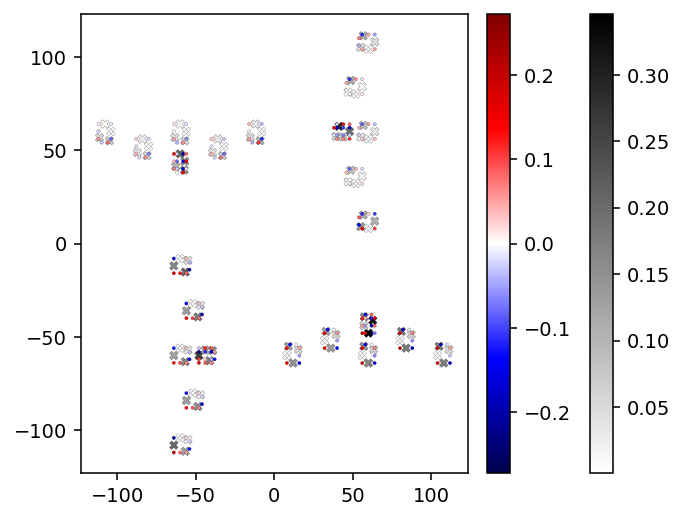

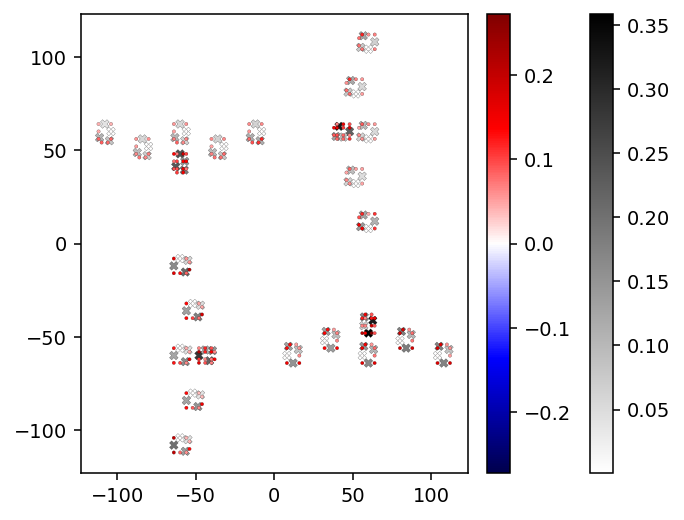

In [108]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["mean-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-mass_flux"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=20, c=roomVentilation["net-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["net-mass_flux"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

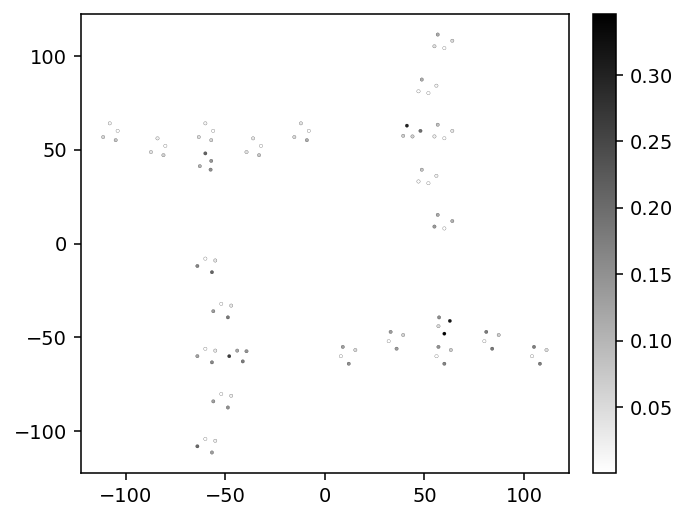

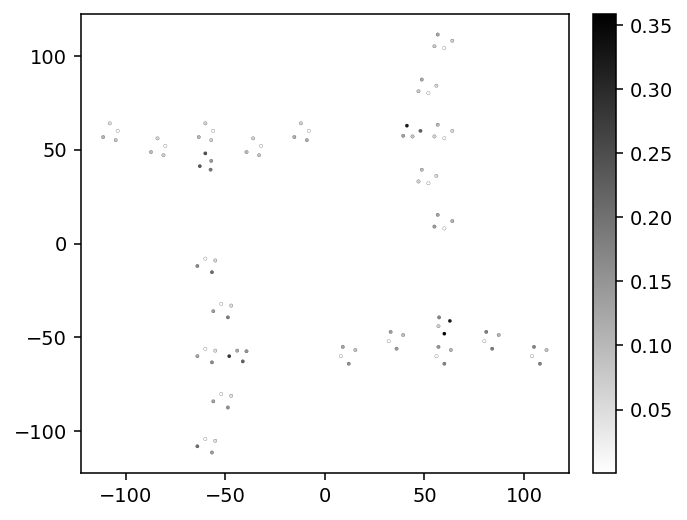

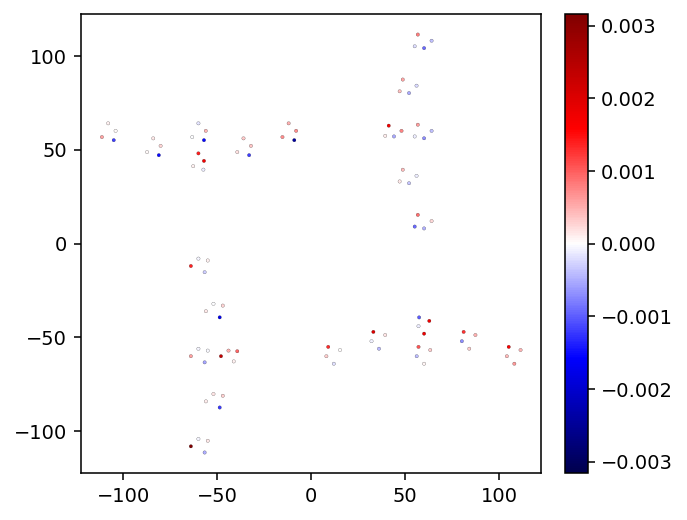

In [109]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["mean-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["net-mass_flux"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomVentilation['x'], roomVentilation['z'], s=4*im_scaling, c=roomVentilation["contResid"], cmap='seismic', edgecolors="black", linewidths=.1, norm = colors.CenteredNorm())
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/residRooms', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

33.

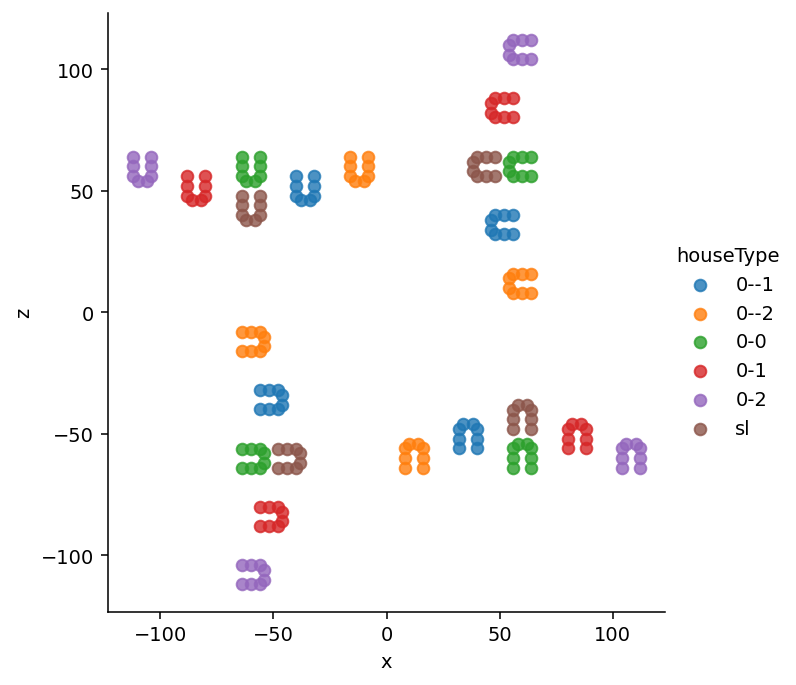

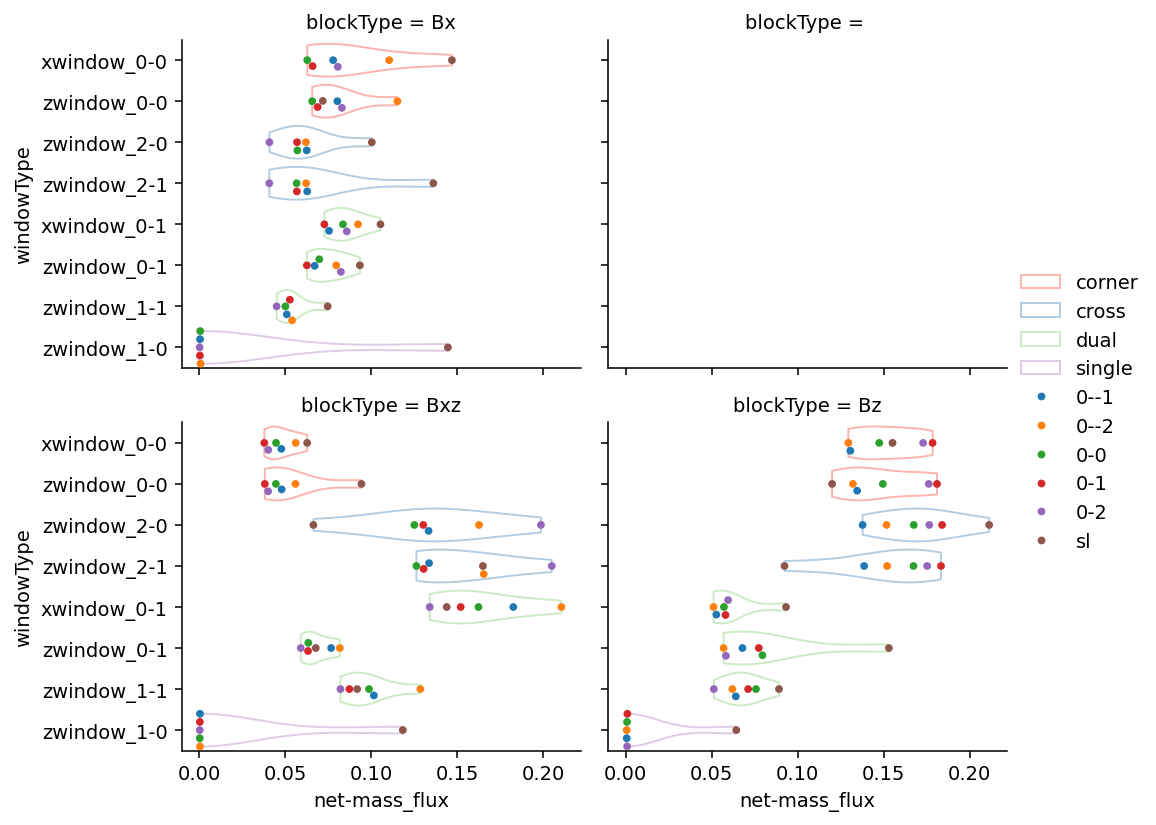

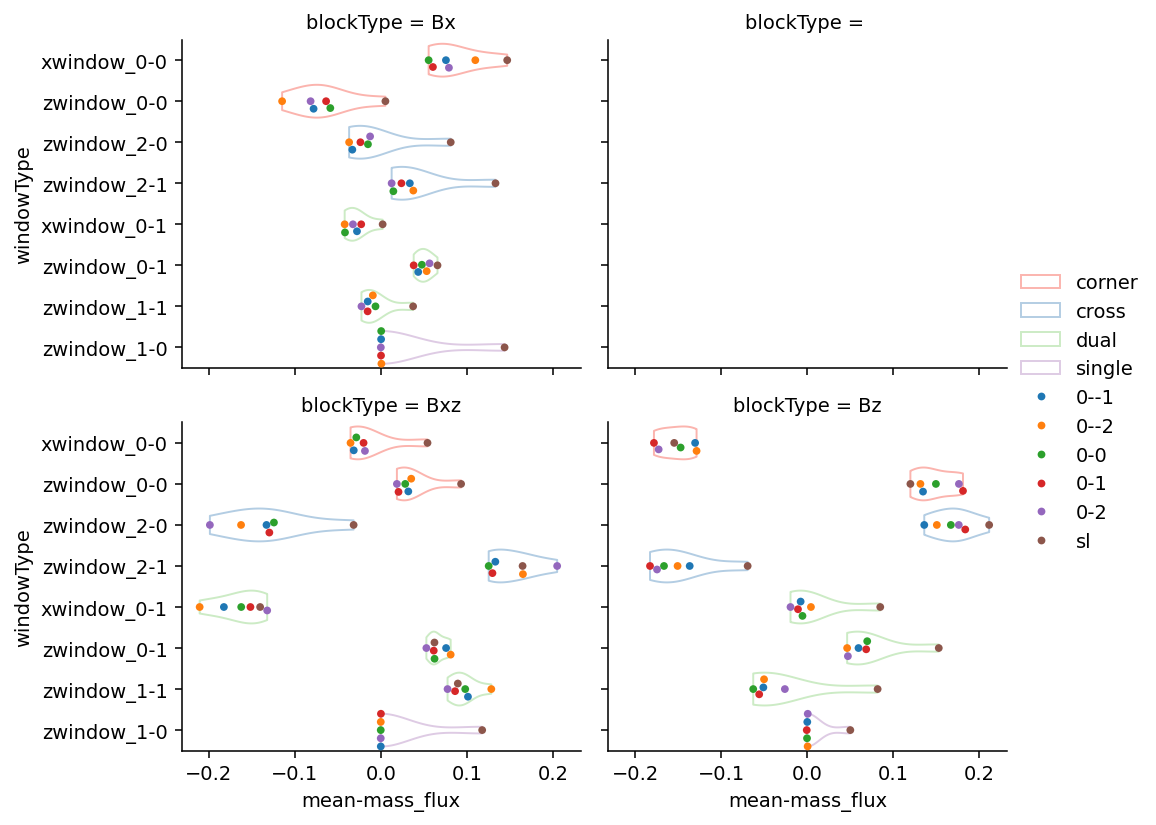

In [110]:
dfWindows = flowStats.loc[flowStats["openingType"].isin(["xwindow", "zwindow"])]

sns.lmplot(data = dfWindows, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/windowKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net-mass_flux", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "windowType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net-mass_flux", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowViolins', bbox_inches="tight")

g = sns.FacetGrid(dfWindows, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean-mass_flux", "windowType", "roomType", inner = None, fill = False, palette = "Pastel1", linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean-mass_flux", "windowType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the s

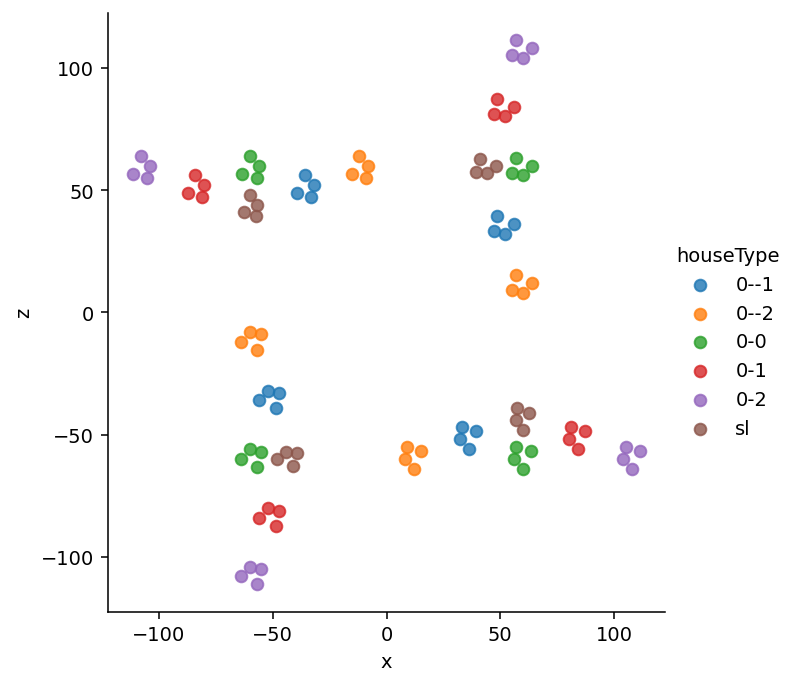

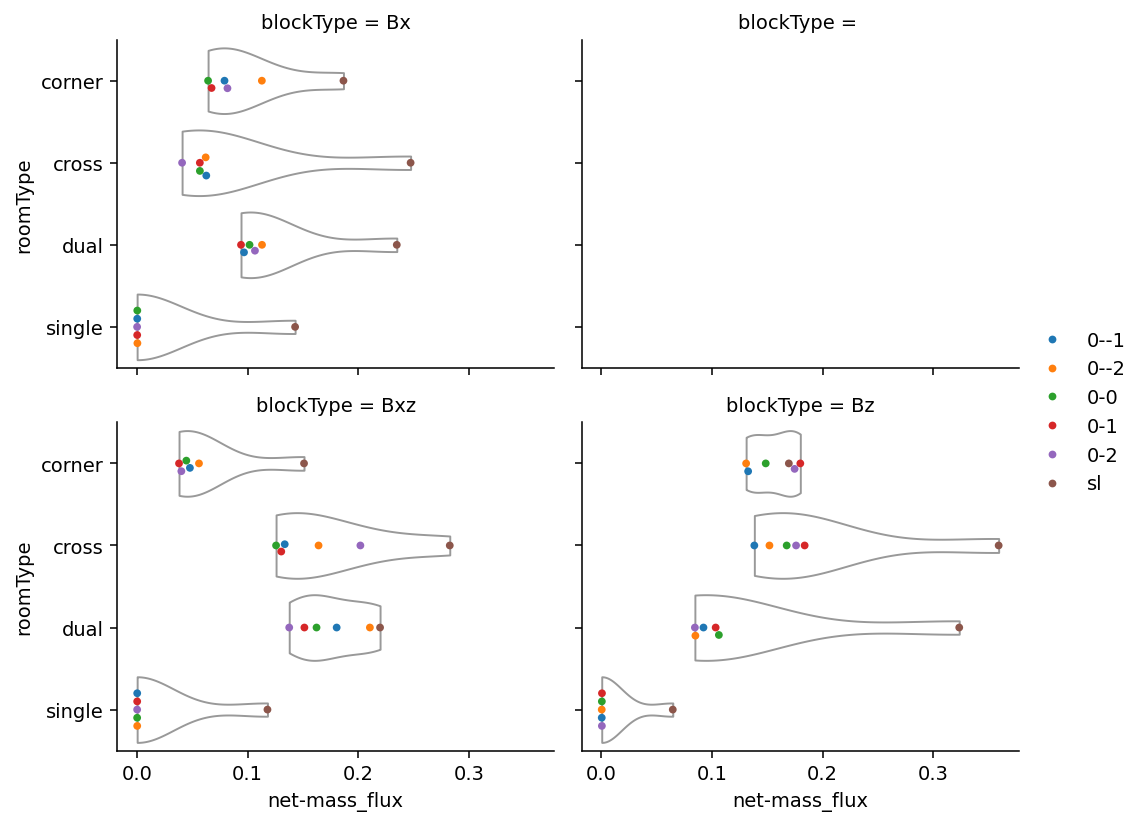

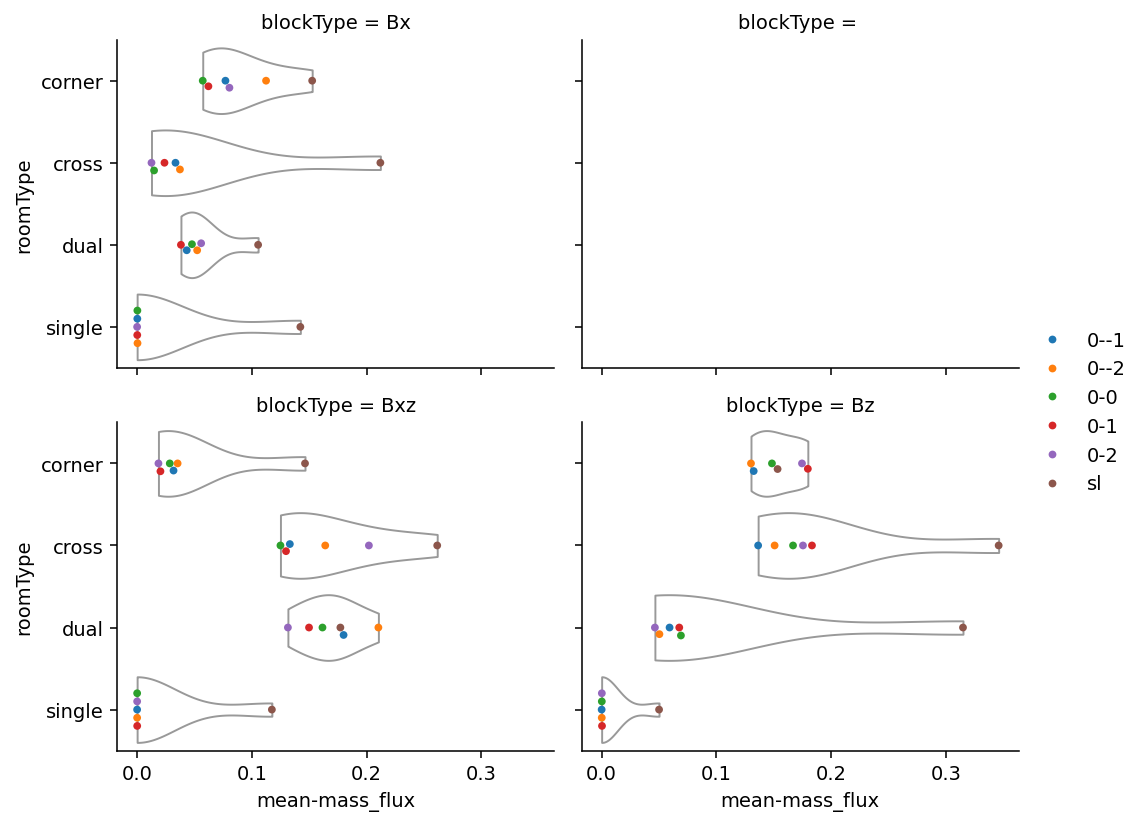

In [111]:
sns.lmplot(data = roomVentilation, x = 'x', y = 'z', hue = 'houseType', fit_reg = False, palette = "tab10")
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/roomKeyLayout', bbox_inches="tight", dpi = 300)

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "net-mass_flux", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "net-mass_flux", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRoomViolins', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.violinplot, "mean-mass_flux", "roomType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.swarmplot, "mean-mass_flux", "roomType", "houseType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRoomViolins', bbox_inches="tight")

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.



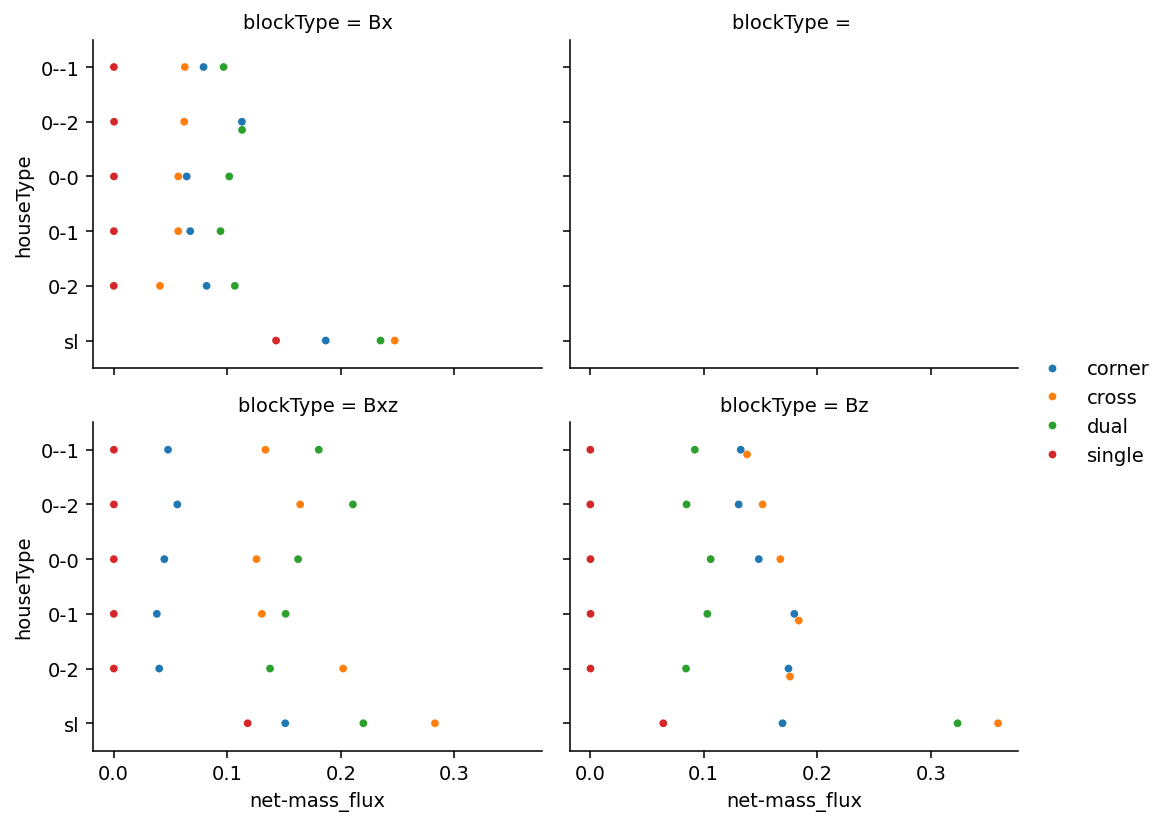

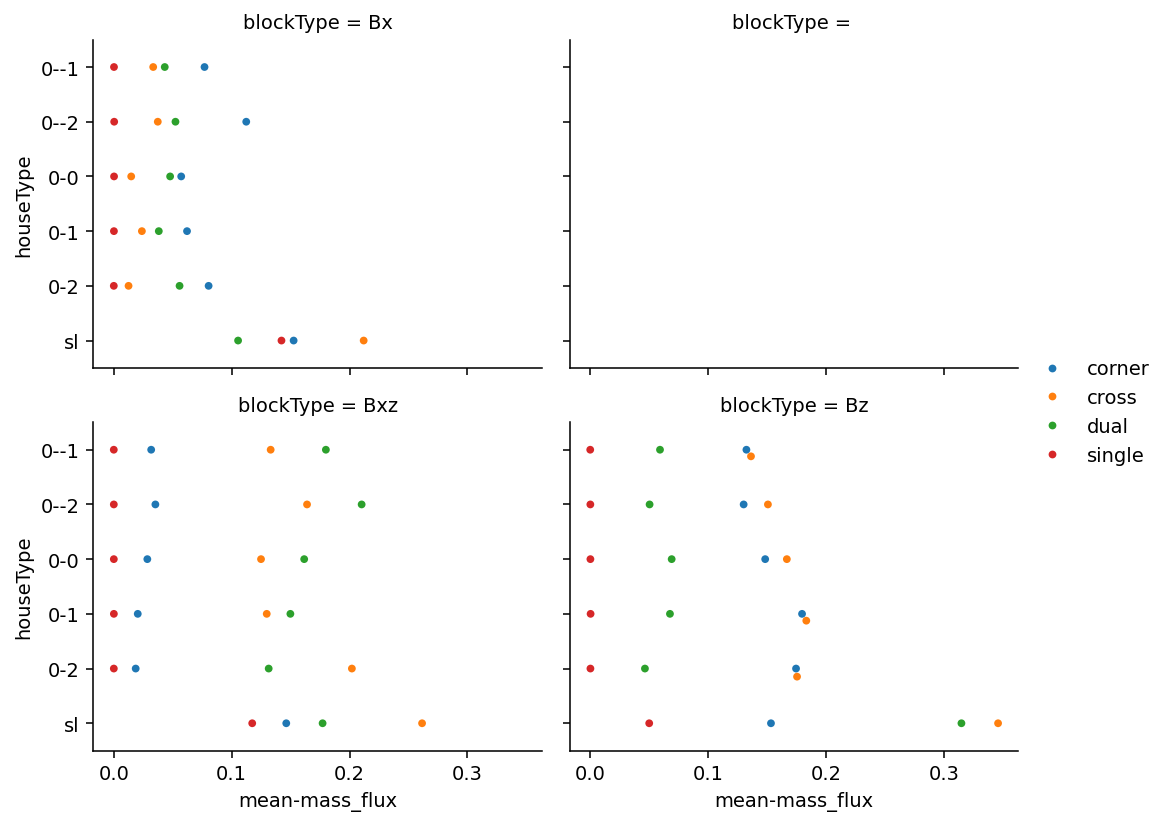

In [112]:
g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "net-mass_flux", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netHouseByRoom', bbox_inches="tight")

g = sns.FacetGrid(roomVentilation, col = "blockType", col_wrap = 2, col_order = ["Bx", '', "Bxz", "Bz"], aspect = 1.25, legend_out = True)
g.map(sns.swarmplot, "mean-mass_flux", "houseType", "roomType", palette = "tab10", size = 4)
g.add_legend()
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanHouseByRoom', bbox_inches="tight")